In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import mean_squared_error, log_loss, r2_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from GBDT.GradientBoostDecisionTree import GBDTClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Setup global plt style
plt.style.use('seaborn-talk')

In [3]:
data = pd.read_csv("./titanic/train.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
x_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
x_catagory = ['Sex', 'Pclass', 'Embarked']
data = data[x_columns + ['Survived']].dropna()
data_x = pd.get_dummies(data[x_columns], columns=x_catagory, drop_first=True)
data_y = data['Survived']

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.5, random_state=1)
(train_x, train_y)

(      Age  SibSp  Parch      Fare  Sex_male  Pclass_2  Pclass_3  Embarked_Q  \
 407   3.0      1      1   18.7500         1         1         0           0   
 353  25.0      1      0   17.8000         1         0         1           0   
 827   1.0      0      2   37.0042         1         1         0           0   
 694  60.0      0      0   26.5500         1         0         0           0   
 856  45.0      1      1  164.8667         0         0         0           0   
 ..    ...    ...    ...       ...       ...       ...       ...         ...   
 182   9.0      4      2   31.3875         1         0         1           0   
 809  33.0      1      0   53.1000         0         0         0           0   
 94   59.0      0      0    7.2500         1         0         1           0   
 292  36.0      0      0   12.8750         1         1         0           0   
 51   21.0      0      0    7.8000         1         0         1           0   
 
      Embarked_S  
 407           1  


## My GBDT

In [5]:
Gbdt = GBDTClassifier(200, 0.1, 'deviance', tree_params={'criterion': 'mse', 'max_depth': 3}, subsample=0.7, random_state=1)
Gbdt.fit(train_x, train_y)

GBDTClassifier(learning_rate=0.1, loss='deviance', n_estimators=200,
               random_state=1, subsample=0.7,
               tree_params={'criterion': 'mse', 'max_depth': 3})

In [6]:
accuracy_score(train_y, Gbdt.predict(train_x))

0.8904494382022472

In [7]:
accuracy_score(test_y, Gbdt.predict(test_x))

0.7837078651685393

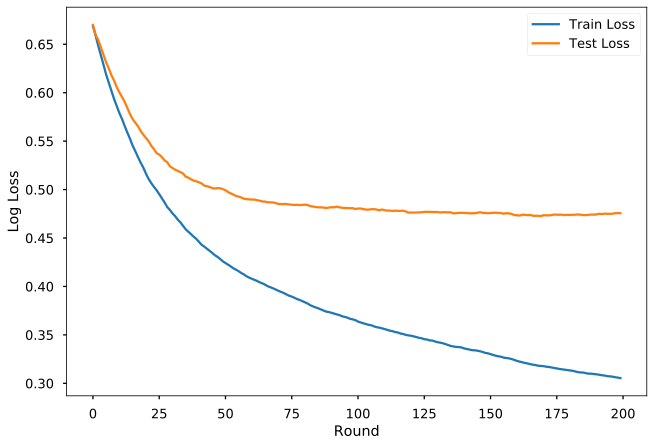

In [8]:
plt.plot(range(len(Gbdt.train_score_)), Gbdt.train_score_, label='Train Loss')
test_loss = [log_loss(test_y, proba) for proba in Gbdt.staged_predict_proba(test_x)]
plt.plot(range(len(test_loss)), test_loss, label='Test Loss')
plt.xlabel('Round')
plt.ylabel('Log Loss')
plt.legend()

In [9]:
Gbdt.feature_importances_

array([0.28749152, 0.08209874, 0.01555092, 0.33722399, 0.18101414,
       0.01701197, 0.04002014, 0.01979336, 0.01979521])

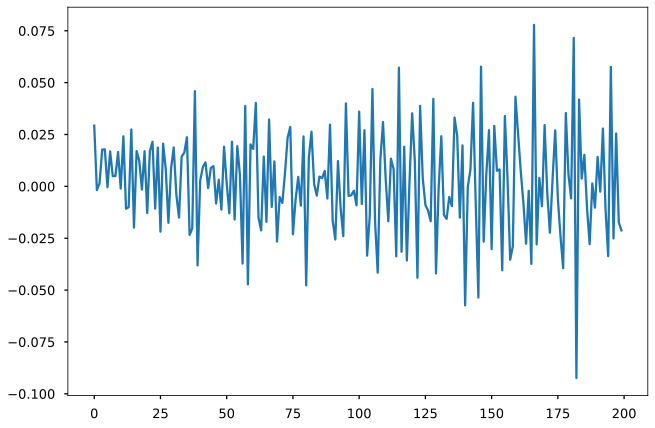

In [10]:
plt.plot(range(len(Gbdt.oob_improvement_)), Gbdt.oob_improvement_)

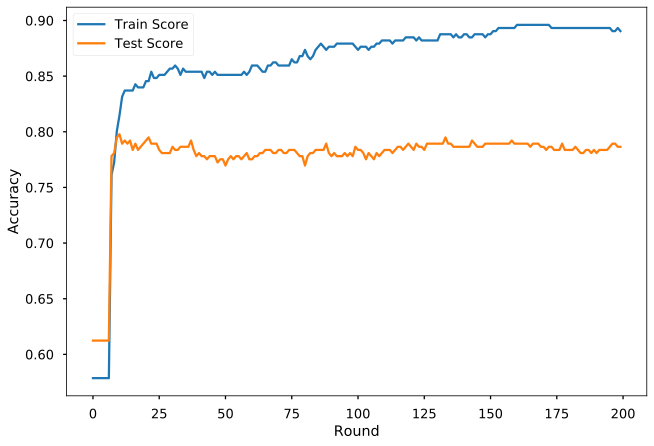

In [11]:
train_scores = [accuracy_score(train_y, pred) for pred in Gbdt.staged_predict(train_x)]
test_scores = [accuracy_score(test_y, pred) for pred in Gbdt.staged_predict(test_x)]
plt.plot(np.arange(len(train_scores)), train_scores, label="Train Score")
plt.plot(np.arange(len(test_scores)), test_scores, label="Test Score")
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

 ## Sklearn GBDT

In [12]:
gbr = GradientBoostingClassifier(criterion='mse', loss='deviance', n_estimators=200, learning_rate=0.1, max_depth=3, subsample=0.7, random_state=1)
gbr.fit(train_x, train_y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [13]:
accuracy_score(train_y, gbr.predict(train_x))

0.9775280898876404

In [14]:
accuracy_score(test_y, gbr.predict(test_x))

0.7837078651685393

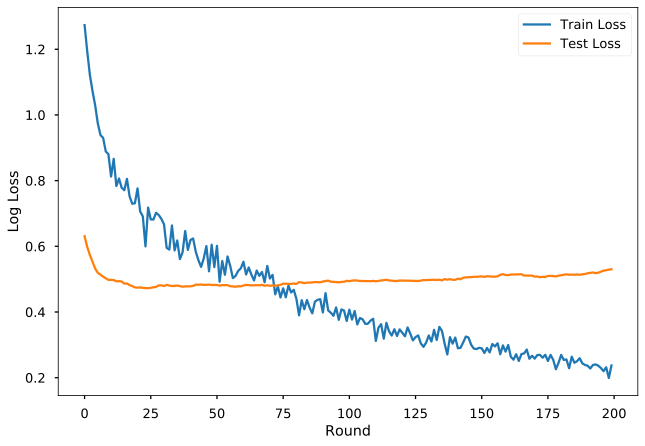

In [15]:
plt.plot(range(len(Gbdt.train_score_)), gbr.train_score_, label='Train Loss')
test_loss = [log_loss(test_y, proba) for proba in gbr.staged_predict_proba(test_x)]
plt.plot(range(len(test_loss)), test_loss, label='Test Loss')
plt.xlabel('Round')
plt.ylabel('Log Loss')
plt.legend()

In [16]:
gbr.feature_importances_

array([0.25187427, 0.06725145, 0.01427496, 0.29507477, 0.27998541,
       0.01145646, 0.05211439, 0.01543229, 0.01253599])

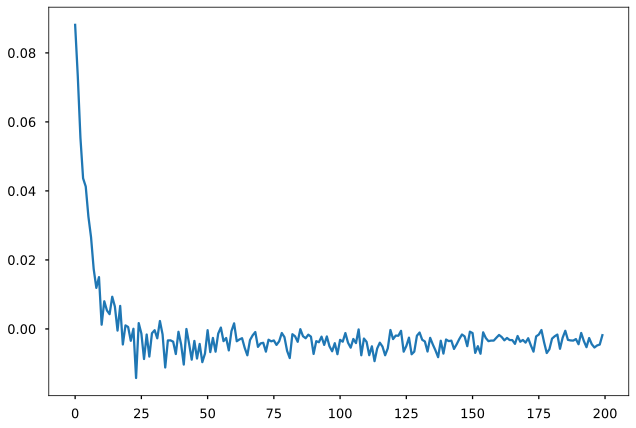

In [17]:
plt.plot(range(len(gbr.oob_improvement_)), gbr.oob_improvement_)

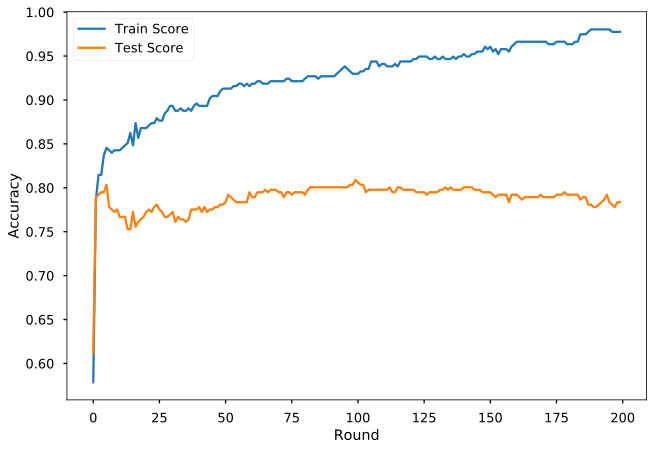

In [18]:
train_scores = [accuracy_score(train_y, pred) for pred in gbr.staged_predict(train_x)]
test_scores = [accuracy_score(test_y, pred) for pred in gbr.staged_predict(test_x)]
plt.plot(np.arange(len(train_scores)), train_scores, label="Train Score")
plt.plot(np.arange(len(test_scores)), test_scores, label="Test Score")
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

## Hyperparameter/Cross Validation

In [19]:
Gbdt = GBDTClassifier(loss='deviance', tree_params={'criterion': 'mse', 'max_depth': 3}, random_state=1)
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
    'subsample': [0.4, 0.6, 0.8, 1.0]
}

gridCV = GridSearchCV(Gbdt, param_grid, scoring='accuracy', n_jobs=-1, return_train_score=True)
gridCV.fit(train_x, train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=GBDTClassifier(learning_rate=0.1, loss='deviance',
                                      n_estimators=100, random_state=1,
                                      subsample=1.0,
                                      tree_params={'criterion': 'mse',
                                                   'max_depth': 3}),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
                         'n_estimators': [50, 100, 200, 500, 1000],
                         'subsample': [0.4, 0.6, 0.8, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [20]:
print(gridCV.best_score_)
print(gridCV.best_params_)

0.8089593114241002
{'learning_rate': 0.01, 'n_estimators': 500, 'subsample': 1.0}


In [21]:
Gbdt = gridCV.best_estimator_
Gbdt.fit(train_x, train_y)
(accuracy_score(train_y, Gbdt.predict(train_x)), accuracy_score(test_y, Gbdt.predict(test_x)))

(0.8539325842696629, 0.7865168539325843)

In [22]:
gbr = GradientBoostingClassifier(criterion='mse', loss='deviance', max_depth=3, random_state=1)
gridCV = GridSearchCV(gbr, param_grid, scoring='accuracy', n_jobs=-1, return_train_score=True)
gridCV.fit(train_x, train_y)
print(gridCV.best_score_)
print(gridCV.best_params_)
gbr = gridCV.best_estimator_
gbr.fit(train_x, train_y)
(accuracy_score(train_y, gbr.predict(train_x)), accuracy_score(test_y, gbr.predict(test_x)))

0.8117762128325507
{'learning_rate': 0.1, 'n_estimators': 50, 'subsample': 0.6}


(0.8960674157303371, 0.7865168539325843)

## Hyper Plot

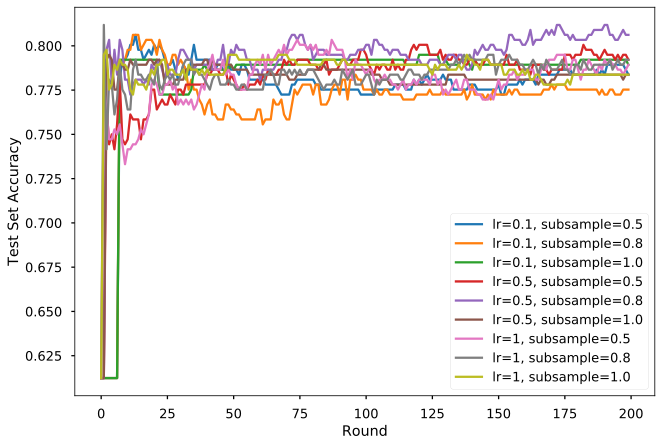

In [23]:
param_grid = {
    'learning_rate': [0.1, 0.5, 1],
    'subsample': [0.5, 0.8, 1.0]
}

for lr in param_grid['learning_rate']:
    for ss in param_grid['subsample']:
        Gbdt = GBDTClassifier(200, lr, 'deviance', tree_params={'criterion': 'mse', 'max_depth': 3}, subsample=ss, random_state=1)
        Gbdt.fit(train_x, train_y)
        scores = [accuracy_score(test_y, pred) for pred in Gbdt.staged_predict(test_x)]
        plt.plot(np.arange(len(scores)), scores, label="lr={}, subsample={}".format(lr, ss))
plt.xlabel('Round')
plt.ylabel('Test Set Accuracy')
plt.legend()

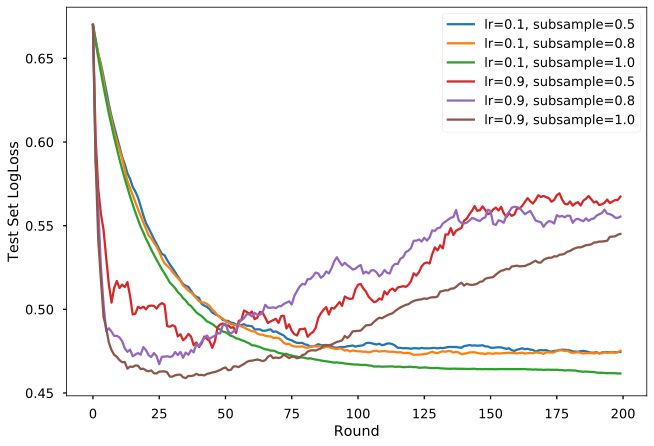

In [24]:
param_grid = {
    'learning_rate': [0.1, 0.9],
    'subsample': [0.5, 0.8, 1.0],
    'tree_depth': [1, 2, 3, 5, 8]
}

for lr in param_grid['learning_rate']:
    for ss in param_grid['subsample']:
        Gbdt = GBDTClassifier(200, lr, 'deviance', tree_params={'criterion': 'mse', 'max_depth': 3}, subsample=ss, random_state=1)
        Gbdt.fit(train_x, train_y)
        scores = [log_loss(test_y, proba) for proba in Gbdt.staged_predict_proba(test_x)]
        plt.plot(np.arange(len(scores)), scores, label="lr={}, subsample={}".format(lr, ss))
plt.xlabel('Round')
plt.ylabel('Test Set LogLoss')
plt.legend()

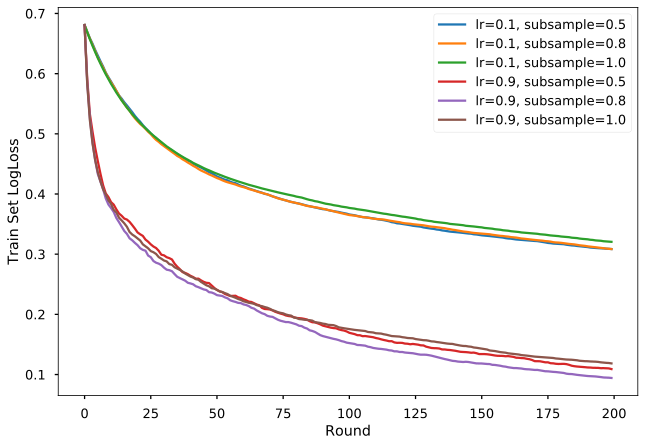

In [25]:
for lr in param_grid['learning_rate']:
    for ss in param_grid['subsample']:
        Gbdt = GBDTClassifier(200, lr, 'deviance', tree_params={'criterion': 'mse', 'max_depth': 3}, subsample=ss, random_state=1)
        Gbdt.fit(train_x, train_y)
        scores = [log_loss(train_y, proba) for proba in Gbdt.staged_predict_proba(train_x)]
        plt.plot(np.arange(len(scores)), scores, label="lr={}, subsample={}".format(lr, ss))
plt.xlabel('Round')
plt.ylabel('Train Set LogLoss')
plt.legend()

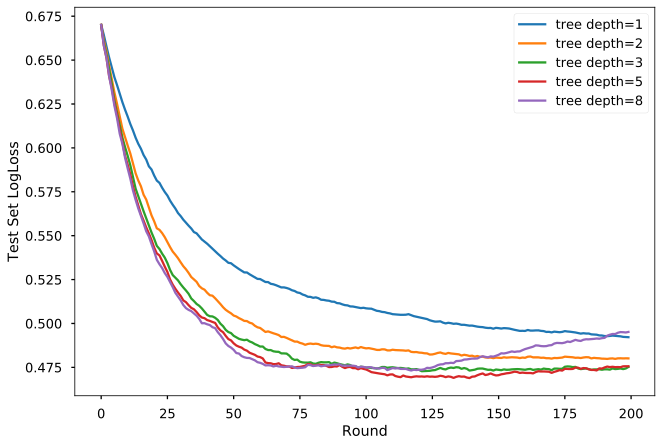

In [26]:
for td in param_grid['tree_depth']:
    Gbdt = GBDTClassifier(200, 0.1, 'deviance', tree_params={'criterion': 'mse', 'max_depth': td}, subsample=0.8, random_state=1)
    Gbdt.fit(train_x, train_y)
    scores = [log_loss(test_y, proba) for proba in Gbdt.staged_predict_proba(test_x)]
    plt.plot(np.arange(len(scores)), scores, label="tree depth={}".format(td))
plt.xlabel('Round')
plt.ylabel('Test Set LogLoss')
plt.legend()

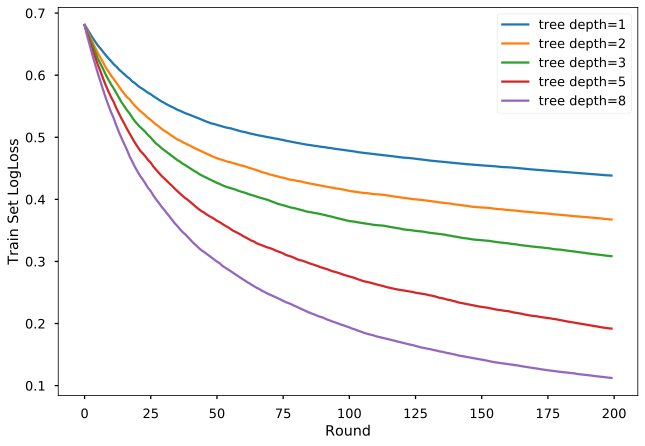

In [27]:
for td in param_grid['tree_depth']:
    Gbdt = GBDTClassifier(200, 0.1, 'deviance', tree_params={'criterion': 'mse', 'max_depth': td}, subsample=0.8, random_state=1)
    Gbdt.fit(train_x, train_y)
    scores = [log_loss(train_y, proba) for proba in Gbdt.staged_predict_proba(train_x)]
    plt.plot(np.arange(len(scores)), scores, label="tree depth={}".format(td))
plt.xlabel('Round')
plt.ylabel('Train Set LogLoss')
plt.legend()